In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
RunningInCOLAB

False

In [2]:
import os


In [4]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.autograd.set_detect_anomaly(True)

In [6]:
dataset = datasets.ImageFolder('collection',
                              transform=transforms.Compose([
                                  #transforms.RandomResizedCrop(224),
                                  transforms.Resize(255),
                                  transforms.CenterCrop(255), #original 224
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])
                                  ]))

class_names = dataset.classes
print(class_names)

['auto', 'bulldozer', 'camion', 'camion_minero', 'camioneta', 'excavadora', 'otro', 'persona']


In [7]:
len(dataset.classes)

8

In [8]:
n_test = int(len(dataset) * 0.2)
n_train = len(dataset) - n_test

train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

print(f'n_train={len(train_dataset)}')
print(f'n_test={len(test_dataset)}')

n_train=4406
n_test=1101


In [9]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [10]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

  if title is not None:
    plt.title(title)

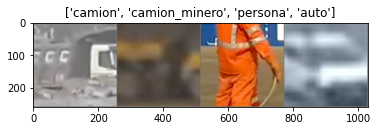

In [12]:
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
device

device(type='cuda', index=0)

In [16]:
for inputs, labels in train_loader:
    inputs = inputs.to("cuda")
    labels = labels.to(device)
    #print(labels)


In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  rs = '------------------------------------------------------------------'
  print('Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best')
  print(rs)
  
  for epoch in range(num_epochs):
    #print(f'Epoch {epoch}/{num_epochs-1}')
    #print('-' * 10)
    
    # Entrenamiento
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
        
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    
    result = {}
    result['train_loss'] = running_loss /len(train_dataset)
    result['train_acc'] = running_corrects.double() / len(train_dataset)
      
    #print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    scheduler.step()
    
    # Validación 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    result['val_loss'] = running_loss /len(test_dataset)
    result['val_acc'] = running_corrects.double() / len(test_dataset)
    epoch_acc = result['val_acc']
      
    #print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    st = '          '
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      st = '   ***    '
        
    print("%5d %11.4f %11.4f %11.4f %11.4f %s" % (epoch, result['train_loss'], result['train_acc'], result['val_acc'], result['val_acc'], st))

  print(rs)
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val accucary: {best_acc:.4f}')

  model.load_state_dict(best_model_wts)
  return model

In [18]:
ft_model = models.resnet18(pretrained=True)
print(ft_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
ft_model.fc = nn.Linear(512, 8) #original 512, 3
ft_model = ft_model.to(device)

ft_criterion = nn.CrossEntropyLoss()
ft_optimizer = torch.optim.SGD(ft_model.parameters(), lr=0.001, momentum=0.9)
ft_scheduler = torch.optim.lr_scheduler.StepLR(ft_optimizer, step_size=7, gamma=0.1)

ft_model = train_model(ft_model, ft_criterion, ft_optimizer, ft_scheduler, num_epochs=25)

Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------


D:\_AZ Proyectos\envs\vepy36\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


    0      0.9560      0.6764      0.8819      0.8819    ***    
    1      0.5737      0.8150      0.9001      0.9001    ***    
    2      0.3954      0.8745      0.9201      0.9201    ***    
    3      0.2943      0.9044      0.9301      0.9301    ***    
    4      0.2288      0.9253      0.9346      0.9346    ***    
    5      0.1920      0.9419      0.9419      0.9419    ***    
    6      0.1975      0.9383      0.9146      0.9146           
    7      0.0964      0.9730      0.9428      0.9428    ***    
    8      0.0527      0.9846      0.9455      0.9455    ***    
    9      0.0610      0.9832      0.9491      0.9491    ***    
   10      0.0653      0.9855      0.9473      0.9473           
   11      0.0457      0.9882      0.9455      0.9455           
   12      0.0385      0.9891      0.9528      0.9528    ***    
   13      0.0491      0.9868      0.9473      0.9473           
   14      0.0320      0.9932      0.9519      0.9519           
   15      0.0441      0.

In [20]:
def visualize_model(model, num_images = 8):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      
      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)



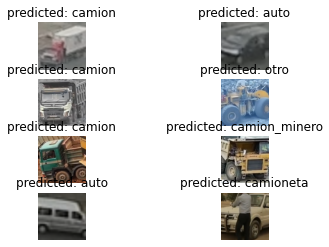

In [21]:
visualize_model(ft_model)

In [23]:
torch.save(ft_model.state_dict(),'model.pth')
torch.save(ft_optimizer.state_dict(), 'optimizer.pth')